# Reinforcement Learning Bonus: DDPG

- As before, please do not modify the folder architecture and do not rename some of the files.

- You will need to fill in the model.py and DDPG.py to solve the DoublePendulum environment.
- Because this is a bonus, there will be no test cases.
- This entire part will be worth 5 points of extra credit for project 4, and will be due on the same day as project 4, so June 6th.

To avoid pain with installation and model training, we strongly recommend you to use Colab for this project. DO NOT use Windows for this project.

## Set up

In [1]:
# mount it if you use Colab
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
# TODO: change the dir to your folder
# %cd /content/drive/MyDrive/YOUR_FOLDER_NAME

In [3]:
%load_ext autoreload
%autoreload 2
%env MUJOCO_GL=egl

env: MUJOCO_GL=egl


In [4]:
!pip install numpy torch wandb swig gymnasium[mujoco] matplotlib termcolor

In [5]:
from utils import *

## Introduction to the Enviroment
We will be training a DDPG agent to solve the DoublePendulum environment. The DoublePendulum environment is a classic control problem where the goal is to balance a double pendulum on a cart.
#### Action Space
The agent can apply a force to the cart in the range of -1 to 1. This is a continuous action space.
#### Observation Space
The observation space is a 9 dimensional vector. The first 1 is the position of the cart, the next 4 are the cosines and sins of different angles of the double pendulum, and the next 3 are the velocities of the cart and the pendulum, and the final 1 is the constrain forces on the cart. You can find more information about these constraint forces [here](https://homes.cs.washington.edu/~todorov/papers/TodorovICRA14.pdf)
#### Reward
The reward can be decomposed into 3 parts. The first part is an alive bonus that pays +10 for every time step the second pendulum is upright. There are 2 penalty terms, one for the tip of the second pendulum moving too much, and another for the cart moving too fast.

You can find more information about the environment [here](https://gymnasium.farama.org/environments/mujoco/inverted_double_pendulum/)

First let us visualize the game and understand the environment.

In [6]:
import gymnasium as gym
import numpy as np
env = gym.make("InvertedDoublePendulum-v5")
env.np_random = np.random.RandomState(42)

eval_env = gym.make("InvertedDoublePendulum-v5", render_mode="rgb_array")
eval_env.np_random = np.random.RandomState(42)

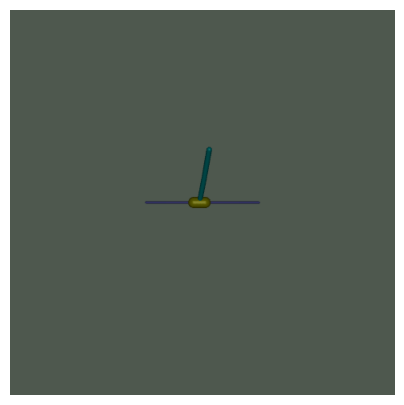

In [7]:
from IPython.display import HTML

frames = []
s, _ = eval_env.reset()

while True:
    a = eval_env.action_space.sample()
    s, r, terminated, truncated, _ = eval_env.step(a)
    frames.append(eval_env.render())
    if terminated or truncated:
        break

anim = animate(frames)
HTML(anim.to_jshtml())

## Model (1 point)
Because the inputs to the model is a 9 dimensional vector, we will use a MLP. Specifically we will follow the architecture in the DDPG paper. For DDPG we have both an Actor and a Critic. The Actor is responsible for selecting the action, and the Critic is responsible for evaluating the action.
#### Actor
The Actor is a 3 layer MLP:
- Layer 1: 400 units, ReLU activation, Fan-in weight initialization, ie each weight is initialized with a uniform distribution in the range of -1/sqrt(fan_in) to 1/sqrt(fan_in)
- Layer 2: 300 units, ReLU activation, Fan-in weight initialization, ie each weight is initialized with a uniform distribution in the range of -1/sqrt(fan_in) to 1/sqrt(fan_in)
- Layer 3: 1 unit, tanh activation, intialized with uniform weights in the range of -0.003 to 0.003
#### Critic
The Critic is a 3 layer MLP:
- Layer 1: 400 units, ReLU activation, Fan-in weight initialization, ie each weight is initialized with a uniform distribution in the range of -1/sqrt(fan_in) to 1/sqrt(fan_in)
- Layer 2: 300 units, ReLU activation, Fan-in weight initialization, ie each weight is initialized with a uniform distribution in the range of -1/sqrt(fan_in) to 1/sqrt(fan_in). Input is the concatenation of the 400 dimension embedding from the state, and the action taken.
- Layer 3: 1 unit, intialized with uniform weights in the range of -0.003 to 0.003

In [8]:
import model

## Exploration (1 point)
Because DDPG is an off policy algorithm, we will use a noise process to encourage exploration. Specifically we will use the Ornstein-Uhlenbeck process. The Ornstein-Uhlenbeck process is a stochastic process that generates temporally correlated noise. The process is defined by the following stochastic differential equation:
$$dx_t = \theta(\mu - x_t)dt + \sigma dW_t$$
Where $\theta$ is the rate of mean reversion, $\mu$ is the long run mean of the process, $\sigma$ is the volatility of the process, and $W_t$ is a Wiener process. We can discretize this process to get the following:
$$x_{t+1} = x_t + \theta(\mu - x_t)dt + \sigma \sqrt{dt}\mathcal{N}(0,1)$$
Where $N(0,1)$ is a sample from the standard normal distribution. We will asume that our steps are of unit length, so we can simplify this to:
$$x_{t+1} = x_t + \theta(\mu - x_t) + \sigma \mathcal{N}(0,1)$$
We will use $\theta = 0.15$, $\mu = 0$, and $\sigma = 0.2$. We will add this to our action in the following way
$$a_t = \min(\max(\mu(s_t) + x_t, -1), 1)$$
Where $a_t$ is the action taken by the agent, $\mu(s_t)$ is the action selected by the actor, and $x_t$ is the noise generated by the Ornstein-Uhlenbeck process.
Please implement the `OU_Noise` class in DDPG.py

## DDPG (3 points total)
We will be implementing the DDPG algorithm. The DDPG algorithm is a model free, off policy algorithm that combines the actor-critic architecture with the insights of DQN. The algorithm is as follows:
![DDPG](DDPG.png)
Fill in both of the TODO in the `DDPG` class in DDPG.py

In [9]:
import wandb
wandb.login()

wandb: Currently logged in as: anwchatto (anwchatto-ucla) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [10]:
wandb.init(project="inverted-double-pendulum-ddpg")

In [ ]:
import DDPG
import utils
t = DDPG.DDPG(env,
            model.Actor,
            model.Critic,
            use_wandb=True,
            save_path = utils.get_save_path("DDPG","./runs/"))

t.train(10000,
        100,
        100,
        1000,
        100,
        1)

saving to ./runs/DDPG/run10


Q_loss,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▁▂▂▁▂▂▂▇▃▅▅▃▂▃▅▅█
actor_loss,█████████████████████████████▇▅▆▆▄▆▂▃▃▁▃
total_reward,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▁▁▁▄▃▄▃▄▅▃█▅▅
val_mean,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▃▄▄▅▅▇▇█
val_std,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▃▃▄▅▆███
Q_loss,347.12714
actor_loss,-739.87152
total_reward,90.60519
val_mean,209.79633
val_std,65.86641


Episode 0: Time: 0.0042917728424072266, Total Reward: 53.99174959484617, Q Loss: 0, Actor Loss: 0
Episode 1: Time: 0.004436969757080078, Total Reward: 81.94873976669977, Q Loss: 0, Actor Loss: 0
Episode 2: Time: 0.003540515899658203, Total Reward: 63.751895245358156, Q Loss: 0, Actor Loss: 0
Episode 3: Time: 0.003539562225341797, Total Reward: 63.305498440860156, Q Loss: 0, Actor Loss: 0
Episode 4: Time: 0.003203153610229492, Total Reward: 53.818119323199504, Q Loss: 0, Actor Loss: 0
Episode 5: Time: 0.0042400360107421875, Total Reward: 82.47600744317941, Q Loss: 0, Actor Loss: 0
Episode 6: Time: 0.004232883453369141, Total Reward: 82.45374991675449, Q Loss: 0, Actor Loss: 0
Episode 7: Time: 0.04819464683532715, Total Reward: 44.70546854014031, Q Loss: 224.5533905029297, Actor Loss: -0.4763839766383171
Episode 8: Time: 0.07938861846923828, Total Reward: 73.09369525976305, Q Loss: 553.2222023010254, Actor Loss: -13.796590596437454
Episode 9: Time: 0.08833956718444824, Total Reward: 81.9

Like what we did for the DQN, we can also animate one episode of the agent in the DoublePendulum environment.

In [ ]:
total_rewards, frames = t.play_episode(0,True,42,eval_env)
anim = animate(frames)
print(total_rewards)
HTML(anim.to_jshtml())

As we can see, the agent is able to balance the double pendulum and it eventually reaches the equilibrium. However this equilibrium is not a stable equilibrium, so lets see how this model performs with perturbations. To do this, we will perturbe the model every 49 steps with a large input of $\pm 0.75$ N to the cart. We will see how the model performs with this perturbation.

In [ ]:
import torch
frames = []
scores = 0
(s, _), done, ret = eval_env.reset(seed = 42
                                   ), False, 0
t.actor.eval()
S = []
outputs = []
# s, r, terminated, truncated, info = eval_env.step(3)
i = 0
with torch.no_grad():
    while not done:
        # if random.random() < 0.1:
        #     action = random.randint(0,4)
        # else:
        frames.append(eval_env.render())
        output = t.actor(torch.tensor(s).unsqueeze(0).to("cpu").float())
        i+=1
        if i%50 == 49:
            output += 0.75*(np.sign(torch.randn_like(output)))
        s_prime, r, terminated, truncated, info = eval_env.step(output.cpu().numpy().squeeze(0))
        s = s_prime
        ret += r
        done = terminated or truncated

scores += ret

In [ ]:
anim = animate(frames)
print(total_rewards)
HTML(anim.to_jshtml())

You should see that the model is able to recover from the perturbation and is able to balance the double pendulum.